# Prediction
# Data

In [1]:
import pandas as pd

df = pd.read_csv("picklist.csv")
df['teamNumber'] = df['teamNumber'].apply(str)
df['alliance'] =  df["robot"].str.contains("r").map({1:"red", 0:"blue"})
df.head()

,eventCode,matchLevel,matchNumber,match_key,robot,teamNumber,autoStartingLocation,taxi,autoUpper,autoLower,...,upperScore,lowerScore,climbScore,endgameScore,totalScore,climbLevel,wasDefendedMetric,diedMetric,heldCargoMetric,alliance
0,2022ilch,qm,1.0,2022ilch_qm1,r1,8802.0,18.0,Y,0.0,0.0,...,0,0.0,0,0,2,0,0,1,0,red
1,2022ilch,qm,1.0,2022ilch_qm1,b1,7460.0,29.0,Y,1.0,0.0,...,10,0.0,15,15,31,4,1,0,0,blue
2,2022ilch,qm,1.0,2022ilch_qm1,b2,2830.0,29.0,Y,1.0,0.0,...,16,0.0,6,6,28,2,0,0,0,blue
3,2022ilch,qm,1.0,2022ilch_qm1,r3,8880.0,41.0,N,0.0,0.0,...,2,0.0,6,6,8,2,0,0,0,red
4,2022ilch,qm,1.0,2022ilch_qm1,b3,111.0,41.0,Y,5.0,0.0,...,14,1.0,0,0,37,0,1,0,0,blue


# Approach
First determine the profile in metrics (team averages) of an alliance that would win or lose a match. KMeans allows to find the cluster or profiles of alliances by taking into account Midwest 2022 game data.

## Match Results per Alliance Color

In [2]:
def win_loss_draw(group): 
     group = group == group.max() 
     if group.all(): 
         group[:] = 3 #empate 
     else: 
         group = group.map({True: 1, False: 0})  #1 es win y 0 "false"
     return group

match = df.groupby(by=["matchNumber", "alliance"]).agg({"speedRating":"mean",
                                                        "autoScore":"sum",
                                                        "teleopScore":"sum",
                                                        "climbScore":"mean",
                                                        "totalScore":"sum"}).reset_index()  

match['Won/Lost'] = match.groupby('matchNumber')['totalScore'].apply(win_loss_draw)      
match                                                  

,matchNumber,alliance,speedRating,autoScore,teleopScore,climbScore,totalScore,Won/Lost
0,1.0,blue,4.000000,28,41,7.000000,96,1
1,1.0,red,2.666667,4,10,3.333333,28,0
2,2.0,blue,3.666667,24,4,5.333333,50,1
3,2.0,red,2.666667,0,9,3.333333,23,0
4,3.0,blue,3.666667,20,20,8.333333,69,1
...,...,...,...,...,...,...,...,...
153,77.0,red,4.000000,16,32,9.000000,81,1
154,78.0,blue,3.000000,32,34,3.333333,82,1
155,78.0,red,2.666667,12,17,9.000000,62,0
156,79.0,blue,2.666667,10,20,0.000000,34,0


## Generating the profiles

<AxesSubplot: >

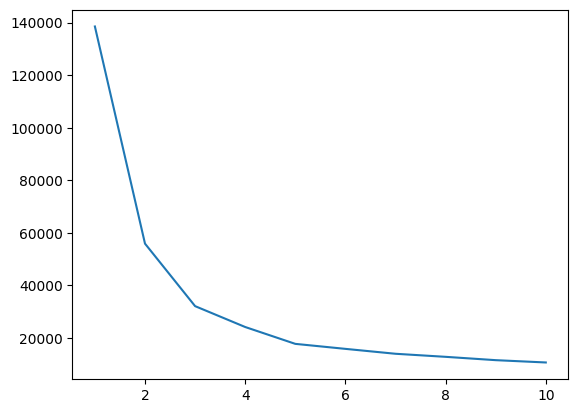

In [3]:
import seaborn as sns
from sklearn.cluster import KMeans
stats_train = match.drop(columns=["matchNumber", "alliance"]).fillna(0)

stats_transformed = stats_train#[["speedRating", "totalScore"]]
wcss = []

for i in range(1, 11):
    clustering = KMeans(n_clusters=i, random_state=123)
    clustering.fit(stats_transformed)
    wcss.append(clustering.inertia_)
    
ks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sns.lineplot(x = ks, y = wcss)

In [10]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=123)
kmeans.fit(stats_transformed)
cluster_labels = kmeans.labels_
match['cluster'] = cluster_labels

In [8]:
import collections, numpy
counter = collections.Counter(cluster_labels)
counter

Counter({2: 30, 1: 65, 0: 63})

## Profiles
Considering the distribution of cluster 1, where there are more winners than losers in the cluster, and the distribution of cluster 2, where there are more losers than winners in the cluster we're going to be determining which alliance is going to win.

In [11]:
def cluster_stats(columns):
    output = pd.DataFrame({'cluster':[ i for i in range(n_clusters)]})
    for column in columns:
        lst = []
        for i in range(n_clusters):
            if column == "Won/Lost":
                print(collections.Counter(match[match['cluster'] == i][column]))
                mean = 0
            else:
                mean = match[match['cluster'] == i].describe()[column]['mean']
            lst.append([i, round(mean,2)])
        df = pd.DataFrame(lst)
        df.columns = ['cluster', column]
        output = pd.merge(output, df, on='cluster', how='outer')
    return output

columns = stats_transformed.columns
cluster_stats(columns)

Counter({1: 52, 0: 10})
Counter({0: 67, 1: 25, 3: 4})


,cluster,speedRating,autoScore,teleopScore,climbScore,totalScore,Won/Lost
0,0,3.44,18.19,34.03,6.76,78.18,0
1,1,2.87,7.79,12.30,4.53,38.07,0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8318c2b8-96d4-4254-8bf9-40651ea68923' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>